# Dataset with 1D normalized signal segments

In [2]:
import os
import re
import random
import numpy as np
import scipy.signal as sgn
import matplotlib.pyplot as plt

## Hold out patients for test set

In [3]:
# use same seed to keep the same patients in test set
np.random.seed(3)

als_test = np.random.randint(1, 14)
control_test = np.random.randint(1, 17)
hunt_test = np.random.randint(1, 21)
park_test = np.random.randint(1, 16)

print('ALS patient for test set:', als_test)
print('Huntington\'s patient for test set:', hunt_test)
print('Parkinson\'s patient for test set:', park_test)
print('Control subject for test set:', control_test)

ALS patient for test set: 11
Huntington's patient for test set: 4
Parkinson's patient for test set: 9
Control subject for test set: 9


## Downsampling original signal

The original signals have been sampled at 300Hz. Therefore each 30 second segment is represented by a 9000 long array.

Since we are studying gait behaviour, the frequencies of interest will be significantly lower than the Nyquist frequency for this sampling rate. Besides, for later processes, working with very big arrays will be cumbersome and inefficient.

Thus the signal segments will be downsampled by a factor of 10, hoping that the bulk of the information we need will not be lost. The ```decimate``` function from ```scipy.signal``` will be used ([see reference](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.signal.decimate.html)).

Let's see an example:

In [5]:
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/interim/normalized-signals')

filename = random.choice(os.listdir(in_dir))

In [6]:
signal = np.load(os.path.join(in_dir, filename))
signal_downsampled = sgn.decimate(signal, 10)

Text(0, 0.5, 'Standardized voltage')

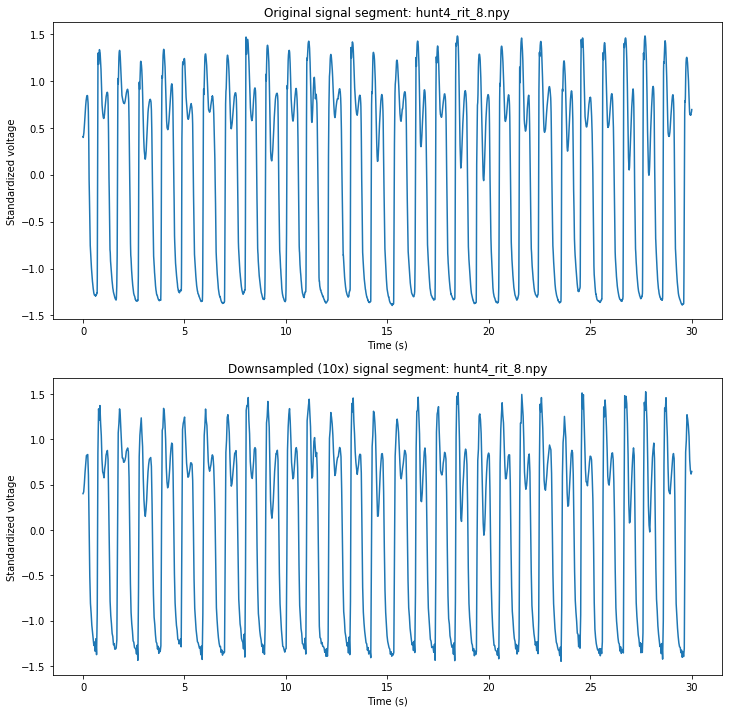

In [7]:
signal = np.load(os.path.join(in_dir, filename))
signal_downsampled = sgn.decimate(signal, 10)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(np.linspace(0, 30, len(signal)), signal, label='original')
axes[0].set_title(f'Original signal segment: {filename}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Standardized voltage')

axes[1].plot(np.linspace(0, 30, len(signal_downsampled)), signal_downsampled, label='downsampled')
axes[1].set_title(f'Downsampled (10x) signal segment: {filename}')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Standardized voltage')

In [ ]:
## filtering?
# signal_downsampled_fir = sgn.decimate(signal, 10, ftype='fir')

# b, a = sgn.butter(4, 8, fs=300)
# signal_filtered = sgn.filtfilt(b, a, signal)

# axes[2].plot(np.linspace(0, 30, len(signal_downsampled_fir)), signal_downsampled_fir, label='downsampled-fir')
# axes[3].plot(np.linspace(0, 30, len(signal)), signal_filtered, label='filtered')

## Building the dataset

The downsampled arrays will be saved in training+dev and test sets, along with their target labels. Additionally, an array with the names of each segment is saved for each dataset.

In [36]:
# 1D signals dataset
test_filenames = ['als'+str(als_test),
                 'hunt'+str(hunt_test),
                 'control'+str(control_test),
                 'park'+str(park_test)]

classes = {
    'control': 0,
    'als': 1,
    'hunt': 2,
    'park': 3}

test_signals = []
test_labels = []
train_signals = []
train_labels = []
test_info = []
train_info = []

rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/interim/normalized-signals')

for in_filename in os.listdir(in_dir):
    record_name = in_filename.split('_')[0]
    # load npy file
    signal = np.load(os.path.join(in_dir, in_filename))
    signal = sgn.decimate(signal, 10)
    # get label from record name
    disease_match = re.match(r'[a-z]+', record_name)
    disease = disease_match[0]
    label = classes[disease]
    # get segment name
    segment_name = in_filename[:-4]
    
    if record_name in test_filenames:
        test_signals.append(signal)
        test_labels.append(label)
        test_info.append(segment_name)
    
    else:
        train_signals.append(signal)
        train_labels.append(label)
        train_info.append(segment_name)

X_test = np.asarray(test_signals)
Y_test = np.asarray(test_labels)
Y_test = Y_test.reshape((Y_test.shape[0], 1))
Z_test = np.asarray(test_info)
Z_test = Z_test.reshape((Z_test.shape[0], 1))

X_train = np.asarray(train_signals)
Y_train = np.asarray(train_labels)
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Z_train = np.asarray(train_info)
Z_train = Z_train.reshape((Z_train.shape[0], 1))

## Saving the dataset

In [40]:
out_dir = os.path.join(rootdir, 'data', 'processed', 'signals-dataset')

np.savez(os.path.join(out_dir, 'train-dev.npz'), X_train = X_train, Y_train = Y_train, Z_train = Z_train)
np.savez(os.path.join(out_dir, 'test.npz'), X_test = X_test, Y_test = Y_test, Z_test = Z_test)